In [8]:
import requests as req
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [10]:
base_url = r'https://www.sec.gov'
normal_url = r'https://www.sec.gov/Archives/edgar/data/1265107/0001265107-19-000004.txt'
normal_url = normal_url.replace('-','').replace('.txt','/index.json')

# define a url that leads to a 10k document landing page
documents_url = r'https://www.sec.gov/Archives/edgar/data/1265107/000126510719000004/index.json'

# request the url and decode it.
content = req.get(documents_url).json()

for file in content['directory']['item']:
    
    # Grab the filing summary and create a new url leading to the file so we can download it.
    if file['name'] == 'FilingSummary.xml':

        xml_summary = base_url + content['directory']['name'] + "/" + file['name']
        
        print('-' * 100)
        print('File Name: ' + file['name'])
        print('File Path: ' + xml_summary)

----------------------------------------------------------------------------------------------------
File Name: FilingSummary.xml
File Path: https://www.sec.gov/Archives/edgar/data/1265107/000126510719000004/FilingSummary.xml


In [3]:
base_url = xml_summary.replace('FilingSummary.xml', '')

content = req.get(xml_summary).content
soup = BeautifulSoup(content, 'lxml')

reports = soup.find('myreports')

master_reports = []

for report in reports.find_all('report')[:-1]:

    # let's create a dictionary to store all the different parts we need.
    report_dict = {}
    report_dict['name_short'] = report.shortname.text
    report_dict['name_long'] = report.longname.text
    report_dict['position'] = report.position.text
    report_dict['category'] = report.menucategory.text
    report_dict['url'] = base_url + report.htmlfilename.text

    # append the dictionary to the master list.
    master_reports.append(report_dict)


In [4]:
statements_url = []

for report_dict in master_reports:
    
    # define the statements we want to look for.
    item1 = r"Consolidated Balance Sheets"
    item2 = r"Consolidated Statements of Operations and Comprehensive Income (Loss)"
    item3 = r"Consolidated Statements of Cash Flows"
    item4 = r"Consolidated Statements of Stockholder's (Deficit) Equity"
    
    # store them in a list.
    report_list = [item1, item2, item3, item4]
    
    # if the short name can be found in the report list.
    if report_dict['name_short'] in report_list:
        
        # print some info and store it in the statements url.
        print('-'*100)
        print(report_dict['name_short'])
        print(report_dict['url'])
        
        statements_url.append(report_dict['url'])

----------------------------------------------------------------------------------------------------
Consolidated Balance Sheets
https://www.sec.gov/Archives/edgar/data/1265107/000126510719000004/R2.htm
----------------------------------------------------------------------------------------------------
Consolidated Statements of Operations and Comprehensive Income (Loss)
https://www.sec.gov/Archives/edgar/data/1265107/000126510719000004/R4.htm
----------------------------------------------------------------------------------------------------
Consolidated Statements of Cash Flows
https://www.sec.gov/Archives/edgar/data/1265107/000126510719000004/R5.htm
----------------------------------------------------------------------------------------------------
Consolidated Statements of Stockholder's (Deficit) Equity
https://www.sec.gov/Archives/edgar/data/1265107/000126510719000004/R6.htm


In [5]:
statements_data = []

# loop through each statement url
for statement in statements_url:

    # define a dictionary that will store the different parts of the statement.
    statement_data = {}
    statement_data['headers'] = []
    statement_data['sections'] = []
    statement_data['data'] = []
    
    # request the statement file content
    content = req.get(statement).content
    report_soup = BeautifulSoup(content, 'html')

    # find all the rows, figure out what type of row it is, parse the elements, and store in the statement file list.
    for index, row in enumerate(report_soup.table.find_all('tr')):
        
        # first let's get all the elements.
        cols = row.find_all('td')
        
        # if it's a regular row and not a section or a table header
        if (len(row.find_all('th')) == 0 and len(row.find_all('strong')) == 0): 
            reg_row = [ele.text.strip() for ele in cols]
            statement_data['data'].append(reg_row)
            
        # if it's a regular row and a section but not a table header
        elif (len(row.find_all('th')) == 0 and len(row.find_all('strong')) != 0):
            sec_row = cols[0].text.strip()
            statement_data['sections'].append(sec_row)
            
        # finally if it's not any of those it must be a header
        elif (len(row.find_all('th')) != 0):            
            hed_row = [ele.text.strip() for ele in row.find_all('th')]
            statement_data['headers'].append(hed_row)
            
        else:            
            print('We encountered an error.')

    # append it to the master list.
    statements_data.append(statement_data)

In [6]:
income_header =  statements_data[1]['headers'][1]
income_data = statements_data[1]['data']

income_df = pd.DataFrame(income_data)

income_df.index = income_df[0]
income_df.index.name = 'Category'
income_df = income_df.drop(0, axis = 1)

income_df = income_df.replace('[\$,)]','', regex=True )\
                     .replace( '[(]','-', regex=True)\
                     .replace( '', 'NaN', regex=True)

income_df = income_df.astype(float)
income_df.columns = income_header

income_df = income_df.transpose()
income_df


Category,Net revenue,Cost of services,"Selling, general and administrative, including stock-based and long-term incentive compensation",Radio conversion costs,"Amortization of subscriber accounts, deferred contract acquisition costs and other intangible assets",Depreciation,Loss on goodwill impairment,Total operating expenses,Operating income (loss),Interest expense,Unrealized loss on derivative financial instruments,Refinancing expense,Total other expense,Loss before income taxes,Income tax expense (benefit),Net loss,"Unrealized gain on derivative contracts, net","Total other comprehensive income, net of tax",Comprehensive loss
"Dec. 31, 2018",134436.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-316590.0,NaN,NaN,NaN,NaN,NaN,NaN,-376911.0,NaN,NaN,NaN
"Sep. 30, 2018",137156.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12280.0,NaN,NaN,NaN,NaN,NaN,NaN,-33840.0,NaN,NaN,NaN
"Jun. 30, 2018",135013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-201845.0,NaN,NaN,NaN,NaN,NaN,NaN,-241792.0,NaN,NaN,NaN
"Mar. 31, 2018",133753.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12012.0,NaN,NaN,NaN,NaN,NaN,NaN,-26207.0,NaN,NaN,NaN
"Dec. 31, 2017",133546.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14647.0,NaN,NaN,NaN,NaN,NaN,NaN,-14642.0,NaN,NaN,NaN
"Sep. 30, 2017",138211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12896.0,NaN,NaN,NaN,NaN,NaN,NaN,-25536.0,NaN,NaN,NaN
"Jun. 30, 2017",140498.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11848.0,NaN,NaN,NaN,NaN,NaN,NaN,-50104.0,NaN,NaN,NaN
"Mar. 31, 2017",141200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16609.0,NaN,NaN,NaN,NaN,NaN,NaN,-21013.0,NaN,NaN,NaN
"Dec. 31, 2018",540358.0,128939.0,118940.0,0.0,211639.0,11434.0,563549.0,1034501.0,-494143.0,180770.0,3151.0,12238.0,196159.0,-690302.0,-11552.0,-678750.0,14378.0,14378.0,-664372.0
"Dec. 31, 2017",553455.0,119193.0,155902.0,450.0,236788.0,8818.0,0.0,521151.0,32304.0,145492.0,0.0,0.0,145492.0,-113188.0,-1893.0,-111295.0,1582.0,1582.0,-109713.0


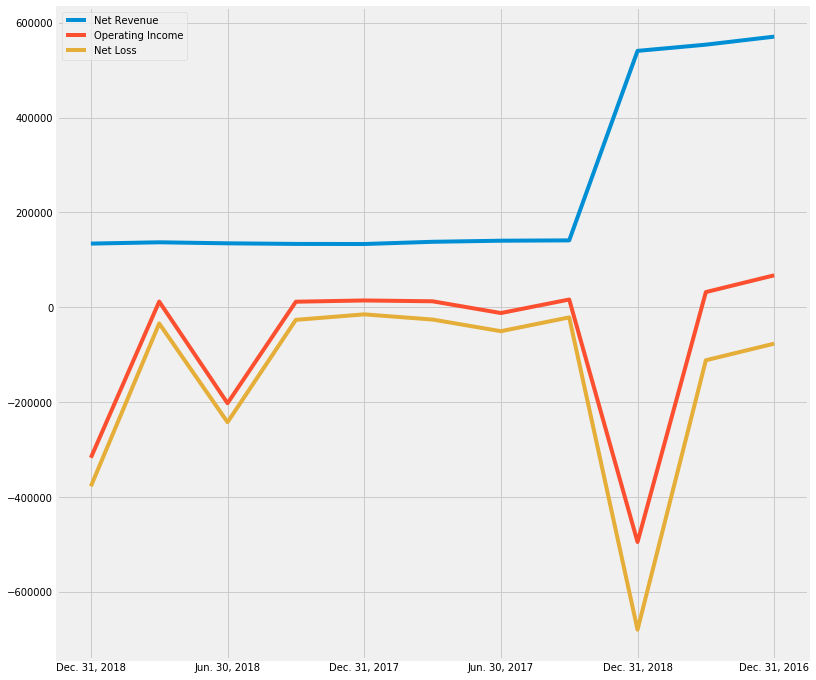

In [7]:
fig, ax = plt.subplots(figsize=(12,12))
income_df['Net revenue'].plot(label='Net Revenue')
income_df['Operating income (loss)'].plot(label = 'Operating Income')
income_df['Net loss'].plot(label='Net Loss')
plt.legend()
plt.show()